# Random Forrest and XGBoost

In [158]:
import os.path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.over_sampling import RandomOverSampler

from xgboost import XGBClassifier

## Data load and preparation

- Data processing step are based on findings during EDA
- Label encoding on categorical data

In [148]:
def get_processed_data(filename, encoder=None, split_target=True, oversampling=False):  
    """Returns processed data for modeling

    Args:
        filename (string): The name of the data file
        encoder (LabelEncoder, optional): Fitted label encoder. Creates and fit a new one if None
        split_target (bool, optional): Set to True if file contains target data. Defaults to True
        oversampling (bool, optional): Oversampling of the minority class if True

    Returns:
        Pandas data frame(s): Processed data
        OrdinalEncoder: Fitted encoder if None was given
    """
    
    # determine file type
    extension = os.path.splitext(filename)[1][1:]
    
    # load all data
    data = pd.read_excel(filename)
    print(f'Loaded data shape: {data.shape}')
        
    # drop duplicates
    data.drop_duplicates(inplace=True, ignore_index=True)
    print(f'Shape w/o duplicates: {data.shape}')
    
    if split_target:
        predictors = data.iloc[:, 0:-1]
        target = data.iloc[:, -1:]
        
        if oversampling:
            predictors, target = perform_oversampling(predictors, target)
    else:
        predictors = data
        
    # drop column 'duration' to avoid data leakage
    predictors.drop('duration', axis=1, inplace=True)
        
    # create ordinal encoder, if necessary
    categories = predictors.select_dtypes('object')
    if encoder == None:
        encoder = OrdinalEncoder()
        encoder.fit(categories)  
        
    ordinal_cats = encoder.transform(categories)
    
    encoded_predictors = pd.concat([predictors.select_dtypes(exclude='object'),
                                     pd.DataFrame(columns=encoder.feature_names_in_, data=ordinal_cats)],
                                    axis=1)
    
    print(f'Encoded data shape: {encoded_predictors.shape}')

    if split_target:
        # convert target yes/no to 0/1
        encoded_target = target.applymap(lambda x: 1 if x == 'yes' else 0)
        return encoded_predictors, encoded_target, encoder
    else:
        return encoded_predictors

## Metric

As discovered during EDA, we face an imbalanced classification problem, and therefore, using the right metric for model training is crucial.

F1 score is considered to be a good metric to measure the classification performance in this case.

## Training

### Split data for training and evaluation

In [149]:
predictors, target, train_encoder = get_processed_data('train_file.xlsx')

# note: stratified target split due to imbalanced target data
x_train, x_val, y_train, y_val = train_test_split(predictors, target,
                                                  train_size=0.8,
                                                  shuffle=True,
                                                  random_state=42,
                                                  stratify=target)

print(f'X train shape: {x_train.shape}; X test shape {x_val.shape}')
print(f'Y train shape: {y_train.shape}; Y test shape {y_val.shape}')

Loaded data shape: (32910, 15)
Shape w/o duplicates: (32902, 15)
Encoded data shape: (32902, 13)
X train shape: (26321, 13); X test shape (6581, 13)
Y train shape: (26321, 1); Y test shape (6581, 1)


In [166]:
x_train.head()

,age,campaign,previous,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
26760,27,2,4,8.0,2.0,6.0,0.0,0.0,2.0,0.0,4.0,1.0,2.0
4974,34,3,0,0.0,2.0,6.0,0.0,0.0,0.0,0.0,7.0,0.0,1.0
28345,35,1,0,0.0,1.0,6.0,0.0,0.0,2.0,0.0,1.0,2.0,1.0
19049,54,1,0,0.0,0.0,2.0,0.0,2.0,0.0,1.0,6.0,2.0,1.0
10525,59,4,0,9.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0


### Compute class weight to handle imbalanced data

In [89]:
class_counts = y_train.value_counts()
class_weights = class_counts[0] / class_counts[1]
class_weights

7.874241402562373

### Random Forrest

#### Baseline

In [90]:
def print_train_val_metrics(model):
    """Prints metrics for training and evaluation data

    Args:
        model : The model to evaluate
    """
    
    y_train_pred = model.predict(x_train)
    y_val_pred = model.predict(x_val)
    
    metric_results = pd.DataFrame(columns=['Training', 'Validation'], index=['Accuracy', 'F1 score', 'ROC AUC'])
    
    metric_results.at['Accuracy', 'Training'] = metrics.accuracy_score(y_train_pred, y_train)
    metric_results.at['F1 score', 'Training'] = metrics.f1_score(y_train_pred, y_train)
    metric_results.at['ROC AUC', 'Training'] = metrics.roc_auc_score(y_train_pred, y_train)
    
    metric_results.at['Accuracy', 'Validation'] = metrics.accuracy_score(y_val_pred, y_val)
    metric_results.at['F1 score', 'Validation'] = metrics.f1_score(y_val_pred, y_val)
    metric_results.at['ROC AUC', 'Validation'] = metrics.roc_auc_score(y_val_pred, y_val)
    
    print(metric_results.astype(float).round(3))

In [91]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(x_train, y_train.values.ravel())

print_train_val_metrics(rf_classifier)

          Training  Validation
Accuracy     0.994       0.887
F1 score     0.975       0.290
ROC AUC      0.994       0.703


Confusion matrix

In [92]:
def plot_cm(labels, predictions, p=0.5, verbose=False):
    """Plots the confusion matrix based on the specified lables and predictions at p.
    
    Args:
      labels (_type_): _description_
      predictions (_type_): _description_
      p (float, optional): _description_. Defaults to 0.5.
    """
    cm = metrics.confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    if verbose:
        print(f'True negatives: {cm[0][0]}')
        print(f'False positives: {cm[0][1]}')
        print(f'False negatives: {cm[1][0]}')
        print(f'True positives: {cm[1][1]}')
        print(f'Total positives: {np.sum(cm[1])}')

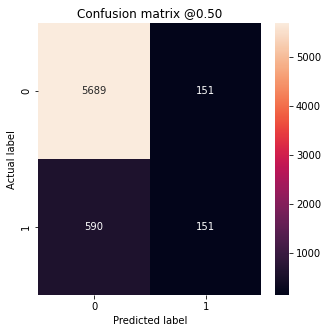

In [93]:
val_pred_rf_baseline = rf_classifier.predict(x_val)
plot_cm(y_val, val_pred_rf_baseline, p=0.5)

#### Class weight

In [94]:
rf_classifier_balanced = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_classifier_balanced.fit(x_train, y_train.values.ravel())

print_train_val_metrics(rf_classifier_balanced)

          Training  Validation
Accuracy     0.994       0.887
F1 score     0.972       0.285
ROC AUC      0.975       0.701


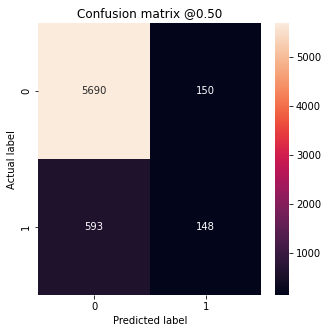

In [95]:
val_pred_rf_balanced = rf_classifier_balanced.predict(x_val)
plot_cm(y_val, val_pred_rf_balanced, p=0.5)

##### Feature importance

In [96]:
def print_feature_importance(features, importance_scores):
    feature_importance = pd.Series(importance_scores, index=features).sort_values(ascending=False)
    sns.barplot(x=feature_importance, y=feature_importance.index)
    plt.title('Feature importance scores')
    plt.xlabel('Feature')
    plt.ylabel('Score')
    plt.show()

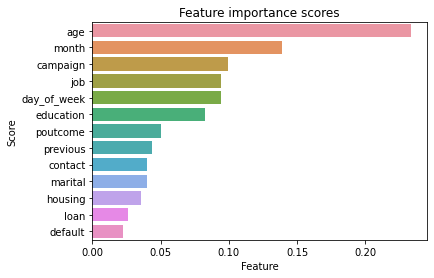

In [97]:
print_feature_importance(x_train.columns, rf_classifier_balanced.feature_importances_)

#### Hyperparameter tuning via grid search

In [98]:
rf_grid_parameters = [{'n_estimators' : [10, 20, 50, 100, 200],
                       'max_depth' : [4, 5, 6, 10, None],
                       'min_samples_split': [2, 4, 10, 20, 40, 100],
                       'max_features': [0.5, 'auto','sqrt','log2', None],
                       'bootstrap': [False, True],
                       'class_weight': ['balanced', 'balanced_subsample', None]}]

In [99]:
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                              param_grid=rf_grid_parameters,
                              scoring='f1',
                              n_jobs=-1)

rf_classifier_grid = rf_grid_search.fit(x_train, y_train.values.ravel())
print(rf_classifier_grid.best_params_)

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


{'bootstrap': True, 'class_weight': 'balanced_subsample', 'max_depth': None, 'max_features': 0.5, 'min_samples_split': 40, 'n_estimators': 100}


In [100]:
print_train_val_metrics(rf_classifier_grid)

          Training  Validation
Accuracy     0.885       0.851
F1 score     0.580       0.436
ROC AUC      0.726       0.658


In [101]:
rf_classifier_grid = RandomForestClassifier(bootstrap=True,
                                            class_weight='balanced',
                                            max_depth=None,
                                            max_features=0.5,
                                            min_samples_split=20,
                                            n_estimators=200,
                                            random_state=42)
rf_classifier_grid.fit(x_train, y_train.values.ravel())

print_train_val_metrics(rf_classifier_grid)

          Training  Validation
Accuracy     0.917       0.864
F1 score     0.683       0.434
ROC AUC      0.787       0.669


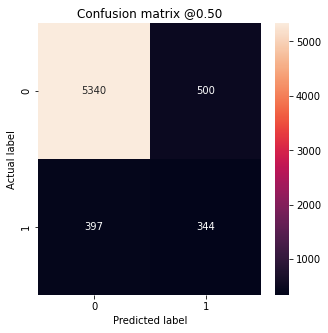

In [102]:
val_pred_rf_grid = rf_classifier_grid.predict(x_val)
plot_cm(y_val, val_pred_rf_grid, p=0.5)

##### Feature importance

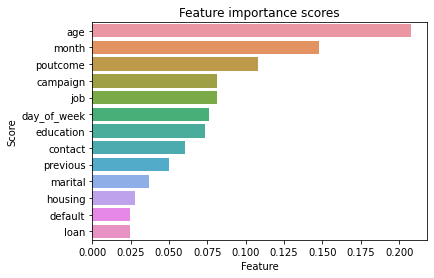

In [103]:
print_feature_importance(x_train.columns, rf_classifier_grid.feature_importances_)

### BalanceBaggingClassifier

In [104]:
bb_classifier = BalancedBaggingClassifier(random_state=42)
bb_classifier.fit(x_train, y_train.values.ravel())

print_train_val_metrics(bb_classifier)

          Training  Validation
Accuracy     0.892       0.806
F1 score     0.665       0.373
ROC AUC      0.752       0.612


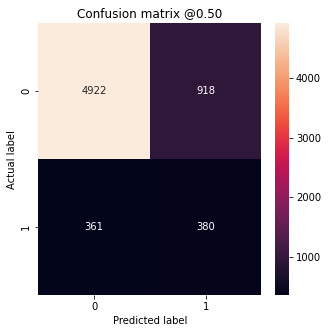

In [105]:
val_pred_bb_classifier = bb_classifier.predict(x_val)
plot_cm(y_val, val_pred_bb_classifier, p=0.5)

### XGBoost

#### Baseline

In [178]:
xgb_classifier = XGBClassifier(objective='binary:logistic', random_state=42)
xgb_classifier.fit(x_train, y_train)

print_train_val_metrics(xgb_classifier)

          Training  Validation
Accuracy     0.924       0.892
F1 score     0.531       0.305
ROC AUC      0.899       0.730


In [194]:
print(xgb_classifier.predict_proba(x_val.iloc[0,:].to_frame().transpose()))

[[0.96053416 0.03946584]]


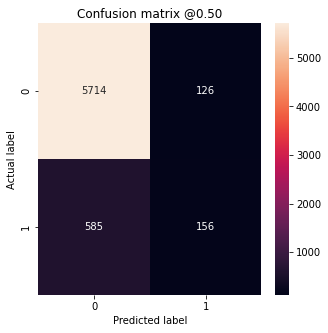

In [168]:
val_pred_xgb_classifier = xgb_classifier.predict(x_val)
plot_cm(y_val, val_pred_xgb_classifier, p=0.5)

#### Class weight

In [108]:
xgb_classifier_scaled = XGBClassifier(scale_pos_weight=class_weights, random_state=42)
xgb_classifier_scaled.fit(x_train, y_train)

print_train_val_metrics(xgb_classifier_scaled)

          Training  Validation
Accuracy     0.871       0.811
F1 score     0.575       0.383
ROC AUC      0.713       0.618


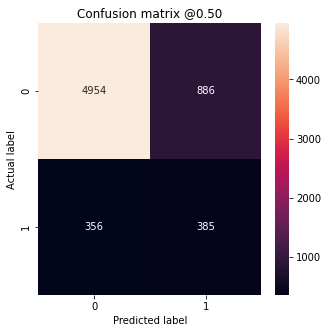

In [109]:
val_pred_xgb_scaled = xgb_classifier_scaled.predict(x_val)
plot_cm(y_val, val_pred_xgb_scaled, p=0.5)

#### Hyperparameter tuning via grid search

In [110]:
xgb_grid_params = {
    'gamma': [0.05, 0.1,1],
    'max_depth': [5, 10, 20],
    'alpha': [0, 0.1, 0.5],
    'lambda': [0.001, 0.01, 0.05],
    'scale_pos_weight': [1, class_weights]
}

xgb_classifier_grid = GridSearchCV(XGBClassifier(objective='binary:logistic',
                                                 random_state=42),
                                  param_grid=xgb_grid_params,
                                  scoring='f1',
                                  n_jobs=-1)

xgb_fitted_grid = xgb_classifier_grid.fit(x_train, y_train.values.ravel())

print(xgb_fitted_grid.best_params_)

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


{'alpha': 0.5, 'gamma': 0.05, 'lambda': 0.05, 'max_depth': 5, 'scale_pos_weight': 7.874241402562373}


In [111]:
xgb_fitted_grid = XGBClassifier(alpha=0.5,
                                gamma=0.05,
                                max_depth=5,
                                scale_pos_weight=class_weights,
                                random_state=42)
xgb_fitted_grid.fit(x_train, y_train)

print_train_val_metrics(xgb_fitted_grid)

          Training  Validation
Accuracy     0.848       0.811
F1 score     0.514       0.395
ROC AUC      0.681       0.623


##### Feature importance via SHAP values

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


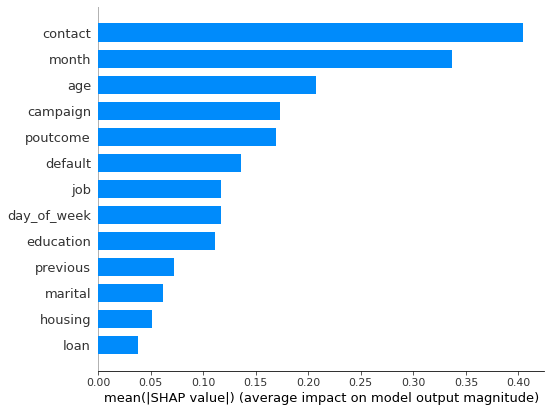

In [112]:
explainer = shap.TreeExplainer(xgb_classifier)
explainer_values = explainer(x_train)

shap.summary_plot(explainer_values, x_train, plot_type="bar")

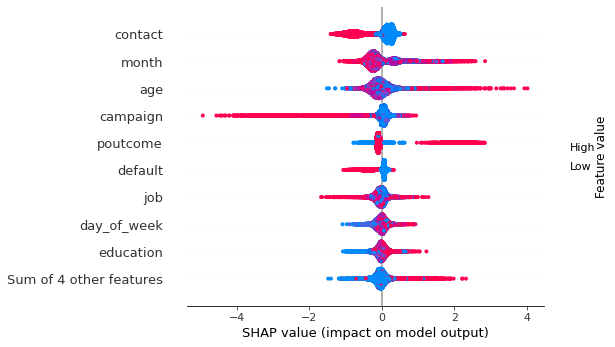

In [150]:
shap.plots.beeswarm(explainer_values)

### Oversampling

In [114]:
def perform_oversampling(x, y):
    """Performs oversampling on the minority class "yes" in the target

    Args:
        x (DataFrame): Predictors
        y (DataFrame): Target

    Returns:
        DataFrames: Predictors and oversampling target data
    """
    print('Orig target balance:')
    print(y.y.value_counts())
    
    ros = RandomOverSampler(sampling_strategy='minority', random_state=42)
    x, y = ros.fit_resample(x, y)
    
    print('Resampled target balance:')
    print(y.y.value_counts())
    
    return x, y

In [115]:
predictors_os, target_os, train_encoder_os = get_processed_data('train_file.xlsx', oversampling=True)

x_train_os, x_val_os, y_train_os, y_val_os = train_test_split(predictors_os, target_os,
                                                              train_size=0.8,
                                                              shuffle=True,
                                                              random_state=42,
                                                              stratify=target_os)

print(f'X train shape: {x_train_os.shape}; X test shape {x_val_os.shape}')
print(f'Y train shape: {y_train_os.shape}; Y test shape {y_val_os.shape}')

Loaded data shape: (32910, 15)
Shape w/o duplicates: (32902, 15)
Orig target balance:
no     29195
yes     3707
Name: y, dtype: int64
Resampled target balance:
no     29195
yes    29195
Name: y, dtype: int64
Encoded data shape: (58390, 13)
X train shape: (46712, 13); X test shape (11678, 13)
Y train shape: (46712, 1); Y test shape (11678, 1)


In [116]:
def print_train_val_metrics_os(model):
    """Prints metrics for training and evaluation of oversampled data

    Args:
        model : The model to evaluate
    """
    
    y_train_pred = model.predict(x_train_os)
    y_val_pred = model.predict(x_val_os)
    
    metric_results = pd.DataFrame(columns=['Training', 'Validation'], index=['Accuracy', 'F1 score', 'ROC AUC'])
    
    metric_results.at['Accuracy', 'Training'] = metrics.accuracy_score(y_train_pred, y_train_os)
    metric_results.at['F1 score', 'Training'] = metrics.f1_score(y_train_pred, y_train_os)
    metric_results.at['ROC AUC', 'Training'] = metrics.roc_auc_score(y_train_pred, y_train_os)
    
    metric_results.at['Accuracy', 'Validation'] = metrics.accuracy_score(y_val_pred, y_val_os)
    metric_results.at['F1 score', 'Validation'] = metrics.f1_score(y_val_pred, y_val_os)
    metric_results.at['ROC AUC', 'Validation'] = metrics.roc_auc_score(y_val_pred, y_val_os)
    
    print(metric_results.astype(float).round(3))

#### Random forest

In [117]:
rf_classifier_grid_os = GridSearchCV(RandomForestClassifier(random_state=42),
                                     param_grid=rf_grid_parameters,
                                     scoring='f1',
                                     n_jobs=-1,
                                     verbose=1)

rf_best_grid_os = rf_classifier_grid_os.fit(x_train_os, y_train_os.values.ravel())
print(rf_best_grid_os.best_params_)

Fitting 5 folds for each of 4500 candidates, totalling 22500 fits


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


{'bootstrap': False, 'class_weight': 'balanced', 'max_depth': None, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200}


Best grid without oversampling:  
{'bootstrap': True, 'class_weight': 'balanced', 'max_depth': None, 'max_features': 0.5, 'min_samples_split': 20, 'n_estimators': 200}  
with oversampling:  
{'bootstrap': False, 'class_weight': 'balanced', 'max_depth': None, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 10}

In [118]:
print_train_val_metrics(rf_best_grid_os)

          Training  Validation
Accuracy     0.992       0.961
F1 score     0.964       0.854
ROC AUC      0.966       0.873


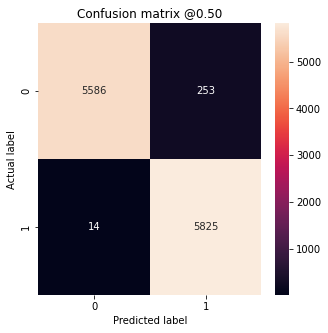

In [119]:
val_pred_rf_os = rf_best_grid_os.predict(x_val_os)
plot_cm(y_val_os, val_pred_rf_os, p=0.5)

#### XGBoost

In [120]:
xgb_classifier_grid_os = GridSearchCV(XGBClassifier(objective='binary:logistic',
                                                    random_state=42),
                                      param_grid=xgb_grid_params,
                                      scoring='f1',
                                      n_jobs=-1,
                                      verbose=0)

xgb_best_grid_os = xgb_classifier_grid_os.fit(x_train_os, y_train_os.values.ravel())

print(xgb_best_grid_os.best_params_)

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


{'alpha': 0.1, 'gamma': 0.1, 'lambda': 0.05, 'max_depth': 20, 'scale_pos_weight': 1}


In [121]:
print_train_val_metrics(xgb_best_grid_os)

          Training  Validation
Accuracy     0.992       0.927
F1 score     0.964       0.754
ROC AUC      0.966       0.803


Best grid without oversampling:  
{'alpha': 0.5, 'gamma': 0.05, 'lambda': 0.001, 'max_depth': 5, 'scale_pos_weight': 7.875640679794983}  
with oversampling:  
{'alpha': 0.1, 'gamma': 0.05, 'lambda': 0.05, 'max_depth': 20, 'scale_pos_weight': 1}

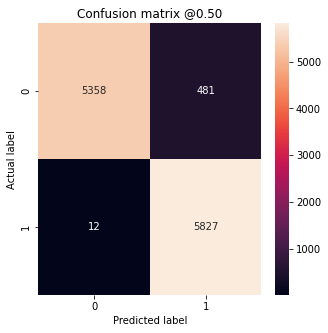

In [122]:
val_pred_xgb_os = xgb_best_grid_os.predict(x_val_os)
plot_cm(y_val_os, val_pred_xgb_os, p=0.5)

## Summary

| Model | Accuracy | F1 score | ROC AUC |
| :- | :- | :- | :-
| RF baseline* |0.887|0.290|0.703|
| RF class weights* |0.887|0.285|0.701|
| RF best grid |0.851|0.436|0.658|
| RF oversampling |0.961|0.854|0.873|
| Balance Bagging |0.806|0.373|0.612|
| XGB baseline* |0.892|0.305|0.730|
| XGB class weights |0.811|0.383|0.618|
| XGB best grid |0.811|0.395|0.623|
| XGB oversampling* |0.927|0.764|0.803|

\* Overfitting

## Test predictions

In [152]:
x_test = get_processed_data('test_file.xlsx', encoder=train_encoder, split_target=False)
x_test.head()

Loaded data shape: (40, 14)
Shape w/o duplicates: (40, 14)
Encoded data shape: (40, 13)


,age,campaign,previous,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,34,4,0,7.0,1.0,3.0,0.0,0.0,0.0,1.0,6.0,2.0,1.0
1,29,1,0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,3.0,2.0,1.0
2,35,2,0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,6.0,4.0,1.0
3,60,1,0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,3.0,0.0,1.0
4,45,2,0,4.0,1.0,6.0,0.0,0.0,0.0,1.0,6.0,4.0,1.0


In [196]:
test_predictions = {}

test_predictions['rf_grid_search'] = rf_classifier_grid_os.predict(x_test)
test_predictions['rf_classifier_grid_os'] = rf_classifier_grid_os.predict(x_test)
test_predictions['xgb_best_grid_os'] = xgb_best_grid_os.predict(x_test)

test_pred_df = pd.DataFrame().from_dict(test_predictions)
test_pred_df.head()

,rf_grid_search,rf_classifier_grid_os,xgb_best_grid_os
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [197]:
test_pred_df.to_csv('test_predictions.csv', index=False)